In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers 
from kaggle_datasets import KaggleDatasets
GCS_PATH = KaggleDatasets().get_gcs_path()
AUTOTUNE = tf.data.experimental.AUTOTUNE
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256,256, 3])
    return image
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)
print(monet_ds)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<_BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>


In [2]:
def generator_model():
    model =tf.keras.Sequential()
    model.add(layers.Input(shape=(256,256,3)))
    model.add(layers.Conv2DTranspose(128,5,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128,5,padding='same',strides=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128,5,padding='same',strides=(3,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128,4,padding='same',strides=(3,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128,4,padding='same',strides=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128,4,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(1,4,padding='same',activation='sigmoid'))
    return model

In [3]:
generator_monet=generator_model()
generator_photo=generator_model()
generated_image=generator_monet(next(iter(monet_ds)),training=False)

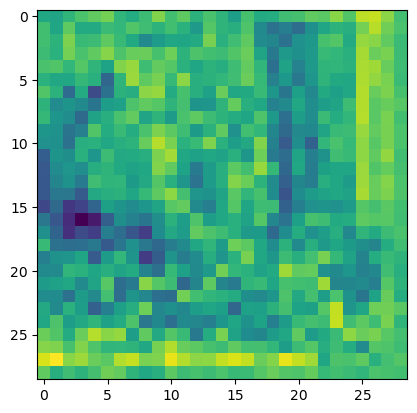

In [4]:
import matplotlib.pyplot as plt
plt.imshow(generated_image[0,:,:,0])

In [5]:
from tensorflow.keras.models import Model
def discrimatior_model():
    model =tf.keras.Sequential()
    model.add(layers.Input(shape=[29,29,1]))
    model.add(layers.Conv2D(128,4,strides=(1,1),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(128,4,strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(256,4,strides=(3,3),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    
    model.add(layers.ZeroPadding2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [6]:
discrimator=discrimatior_model()
print(discrimator(generated_image))

tf.Tensor([[-0.01116156]], shape=(1, 1), dtype=float32)


In [7]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real,fake):
    real_loss=cross_entropy(tf.ones_like(real),real)
    fake_loss=cross_entropy(tf.zeros_like(fake),fake)
    loss=real_loss+fake_loss
    return loss
def generator_loss(fake):
    return cross_entropy(tf.zeros_like(fake),fake)
monet_generator_optimizer=tf.keras.optimizers.Adam(1e-4)
monet_discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)
photo_generator_optimizer=tf.keras.optimizers.Adam(1e-4)
photo_discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [8]:
@tf.function
def train_image(image):
    noise=tf.random.normal([1,100])
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_image=generator(noise,training=True)
        
        real_output=discriminator(image,training=True)
        fake_output=discriminator(generated_image,training=True)
        
        gen_loss=generator_loss(fake_output)
        disc_loss=discriminator_loss(real_output,fake_output)
    gradients_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_discriminator=disc_tape.gradient(gen_loss,discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_discriminator,discriminator.trainable_variables))